In [49]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np
import time
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

tr_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform)
te_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=transform)

indices = list(range(20000))
tr_subset = Subset(tr_set, indices)
indices = list(range(5000))
te_subset = Subset(te_set, indices)

#Loads the training set
tr_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Load test set
te_loader = torch.utils.data.DataLoader(te_subset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Function displays image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class ConNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, device, tr_loader, optimizer, criterion, epochs):
        self.train()

        for epoch in range(epochs):
            for X_tr, y_tr in tr_loader:
                X_tr, y_tr = X_tr.to(device), y_tr.to(device)
                optimizer.zero_grad()
                output = self(X_tr)
                loss = criterion(output, y_tr)
                loss.backward()
                optimizer.step()
    
    def predict(self, device, loader):
        self.eval()  # Set model to evaluation mode
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_te, y_te in loader:
                X_te, y_te = X_te.to(device), y_te.to(device)
                output = self(X_te)
                preds = output.argmax(dim=1, keepdim=True)
                all_preds.extend(preds.cpu().numpy().flatten())
                all_labels.extend(y_te.cpu().numpy())

        return np.array(all_preds), np.array(all_labels)

    def compute_accuracy(self, y_pre, y_true):
        correct = (y_true == y_pre).sum()
        total = len(y_true)
        return correct / total

cnn = ConNeuralNetwork()

In [55]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn.fit(device, tr_loader, optimizer, criterion, epochs=10)

start_time = time.time()
predictions = cnn.predict(device, te_loader[:100])
end_time = time.time()

prediction_time = end_time - start_time
time_per_image = prediction_time / len(te_subset[:100])
print(f"Average prediction time per image: {time_per_image:.6f} seconds")

print('Finished Training')

TypeError: 'DataLoader' object is not subscriptable

In [109]:
indices = list(range(30))
te_subset = Subset(te_set, indices)
# Load test set
te_loader = torch.utils.data.DataLoader(te_subset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

y_pre, y_te = cnn.predict(device, te_loader)

print(y_pre[:10], y_te[:10])
# Compute and print accuracy
print(cnn.compute_accuracy(y_pre, y_te))

[3 1 8 8 6 3 5 2 3 1] [3 8 8 0 6 6 1 6 3 1]
0.5333333333333333


In [50]:
def errors_for_train_sizes_cnn(tr_set, te_loader, train_sizes):
    tr_err_cnn = [] # training error for CNN
    te_err_cnn = [] # testing error for CNN

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for size in train_sizes:
        indices = list(range(size))
        tr_subset = Subset(tr_set, indices)
        tr_loader = torch.utils.data.DataLoader(tr_subset, batch_size=4, shuffle=True, num_workers=2)
        
        cnn = ConNeuralNetwork()

        # Train the model
        cnn.fit(device, tr_loader, optimizer, criterion, epochs=10)
        
        # Check accuracy for model on training and testing data
        tr_acc = cnn.compute_accuracy(device, tr_loader)
        te_acc = cnn.compute_accuracy(device, te_loader)
        
        tr_err_cnn.append(1 - tr_acc)
        te_err_cnn.append(1 - te_acc)

    return tr_err_cnn, te_err_cnn

In [51]:
def plot_errors_for_train_sizes_cnn(tr_err_cnn, te_err_cnn, train_sizes):

    plt.semilogx(train_sizes, tr_err_cnn, label='tr_cnn', marker='x', color='orange')
    plt.semilogx(train_sizes, te_err_cnn, label='te_cnn', linestyle='--', marker='x', color='orange')

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')

    plt.legend()

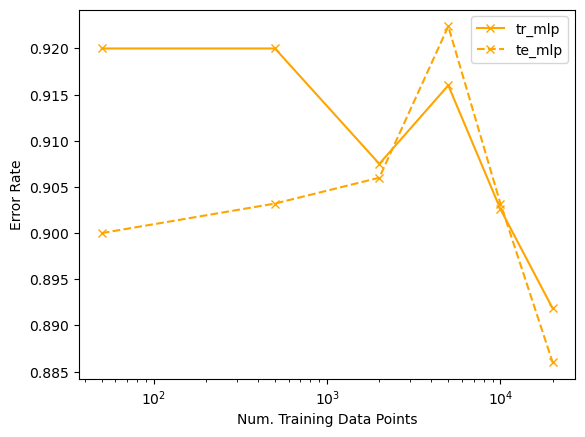

In [53]:
train_sizes = [50, 500, 2000, 5000, 10000, 20000]
tr_err, te_err = errors_for_train_sizes_cnn(tr_set, te_loader, train_sizes)
plot_errors_for_train_sizes_cnn(tr_err, te_err, train_sizes)

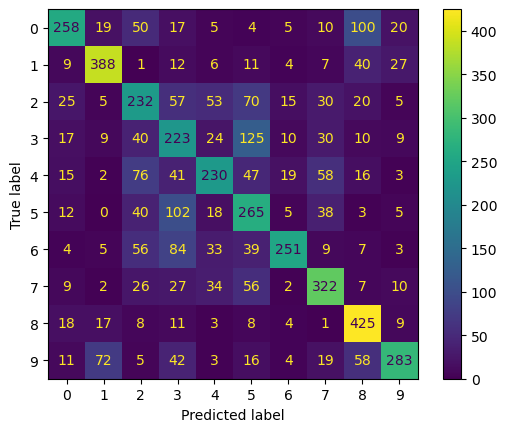

In [114]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model):

    # Make predictions on training and testing data
    y_pre, y_te = model.predict(device, te_loader)


    # Evaluate confusion matrix using your function compute_confusion_matrix
    cm = confusion_matrix(y_te, y_pre)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

plot_confusion_matrix(cnn)

# MLP Classification

In [20]:
X_tr = np.array([tr_set[i][0].numpy() for i in range(len(tr_set))])
y_tr = np.array([tr_set[i][1] for i in range(len(tr_set))])
X_te = np.array([te_set[i][0].numpy() for i in range(len(te_set))])
y_te = np.array([te_set[i][1] for i in range(len(te_set))])

print(y_tr, y_te)

[6 9 9 ... 9 1 1] [3 8 8 ... 5 1 7]


In [19]:
from sklearn.preprocessing import StandardScaler

def scale_data(X_tr, X_te):

    X_tr_flat = X_tr.reshape(X_tr.shape[0], -1)
    X_te_flat = X_te.reshape(X_te.shape[0], -1)

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr_flat)
    X_te_scaled = scaler.transform(X_te_flat)

    return X_tr_scaled, X_te_scaled

X_tr_scaled, X_te_scaled = scale_data(X_tr, X_te)

[[-0.9768241  -1.2029006  -1.1219634  ...  0.40326446 -0.45860013
  -0.64140236]
 [ 0.31723994 -0.05715427 -0.3606105  ...  0.3878547   0.43080652
   0.44823775]
 [ 1.693034    1.6959755   1.688121   ... -0.4750917  -0.4739347
  -0.45979568]
 ...
 [-1.3037455  -1.2443131  -1.2327057  ... -0.56755024 -0.73462284
  -0.97434807]
 [ 0.7940003   0.7710961   0.7468119  ...  0.8501473   0.8755098
   0.8568527 ]
 [ 1.3388692   1.4613047   1.4251082  ...  0.9117863   0.73749846
   0.70551383]]


In [41]:
from sklearn.neural_network import MLPClassifier

def errors_for_train_sizes_mlp(X_tr, y_tr, X_te, y_te, seed, train_sizes):
    # append error rates to the following lists
    tr_err_mlp = [] # training error rates for MLP
    te_err_mlp = [] # testing error rates for MLP

    for size in train_sizes:
        X_tr_subset = X_tr[:size]
        y_tr_subset = y_tr[:size]

        mlp = MLPClassifier(hidden_layer_sizes=64, activation='relu', solver='sgd', learning_rate_init=0.001, batch_size=256, random_state=seed, max_iter=500)
        mlp.fit(X_tr_subset, y_tr_subset)

        tr_err_mlp.append(1-mlp.score(X_tr_subset, y_tr_subset))
        te_err_mlp.append(1-mlp.score(X_te, y_te))
        print(1-mlp.score(X_tr_subset, y_tr_subset))
   
    return tr_err_mlp, te_err_mlp

In [36]:
def plot_errors_for_train_sizes_mlp(tr_err_mlp, te_err_mlp, train_sizes):

    plt.semilogx(train_sizes, tr_err_mlp, label='tr_mlp', marker='x', color='orange')
    plt.semilogx(train_sizes, te_err_mlp, label='te_mlp', linestyle='--', marker='x', color='orange')

    plt.xlabel('Num. Training Data Points')
    plt.ylabel('Error Rate')

    plt.legend()

c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


0.0


c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.0


c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.0004999999999999449


c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.0006000000000000449


c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.0007000000000000339


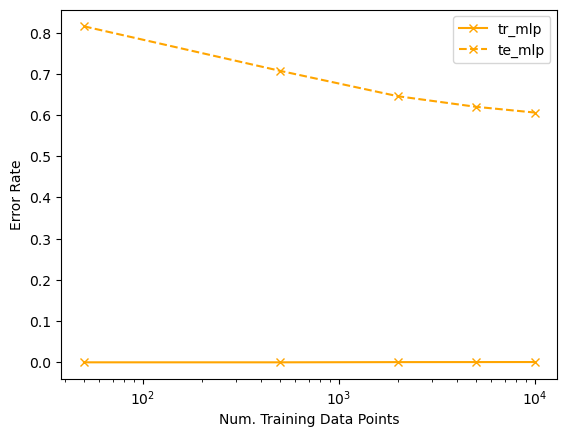

In [42]:
train_sizes = [50, 500, 2000, 5000, 10000]
tr_err_mlp, te_err_mlp = errors_for_train_sizes_mlp(X_tr_scaled, y_tr, X_te_scaled, y_te, seed, train_sizes)
plot_errors_for_train_sizes_mlp(tr_err_mlp, te_err_mlp, train_sizes)

In [58]:

mlp = MLPClassifier(hidden_layer_sizes=256, activation='relu', solver='sgd', learning_rate_init=0.001, batch_size=256, random_state=seed, max_iter=1000)
mlp.fit(X_tr_scaled[:1000], y_tr[:1000])
start_time = time.time()
predictions = mlp.predict(X_te_scaled)
end_time = time.time()

prediction_time = end_time - start_time
time_per_image = prediction_time / len(X_te_scaled)
print(f"Average prediction time per image: {time_per_image:.6f} seconds")
print("Score is: ", mlp.score(X_te_scaled, y_te))

Average prediction time per image: 0.000014 seconds
Score is:  0.3485


10000 0.3485


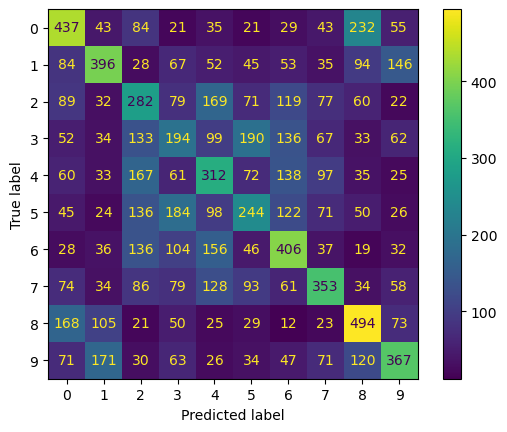

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model):

    # Make predictions on training and testing data
    y_pre = model.predict(X_te_scaled)
    print(len(X_te_scaled), model.score(X_te_scaled, y_te))


    # Evaluate confusion matrix using your function compute_confusion_matrix
    cm = confusion_matrix(y_te, y_pre)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

plot_confusion_matrix(mlp)

In [48]:
mlp = MLPClassifier(hidden_layer_sizes=(512), activation='relu', solver='sgd', learning_rate_init=0.001, batch_size=256, random_state=seed, max_iter=1000)
mlp.fit(X_tr_scaled[:10000], y_tr[:10000])
print("Score is: ", mlp.score(X_te_scaled, y_te))

c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Score is:  0.3773
